# Load Volve simulated data and train data autoencoder

In [1]:
from __future__ import print_function
#load libraries
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter

import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import time
import scipy.io as sio
import math
import pandas as pd
import subprocess
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

(124, 157, 35)
0.0
1.0


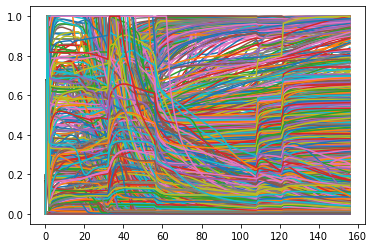

In [3]:
D0 = np.load("data/D0.npy")
print(D0.shape)
print(np.min(D0))
print(np.max(D0))

#QC data
plt.figure()
for j in range(D0.shape[-1]):
    for i in range(D0.shape[0]):
        plt.plot(D0[i,:,j])

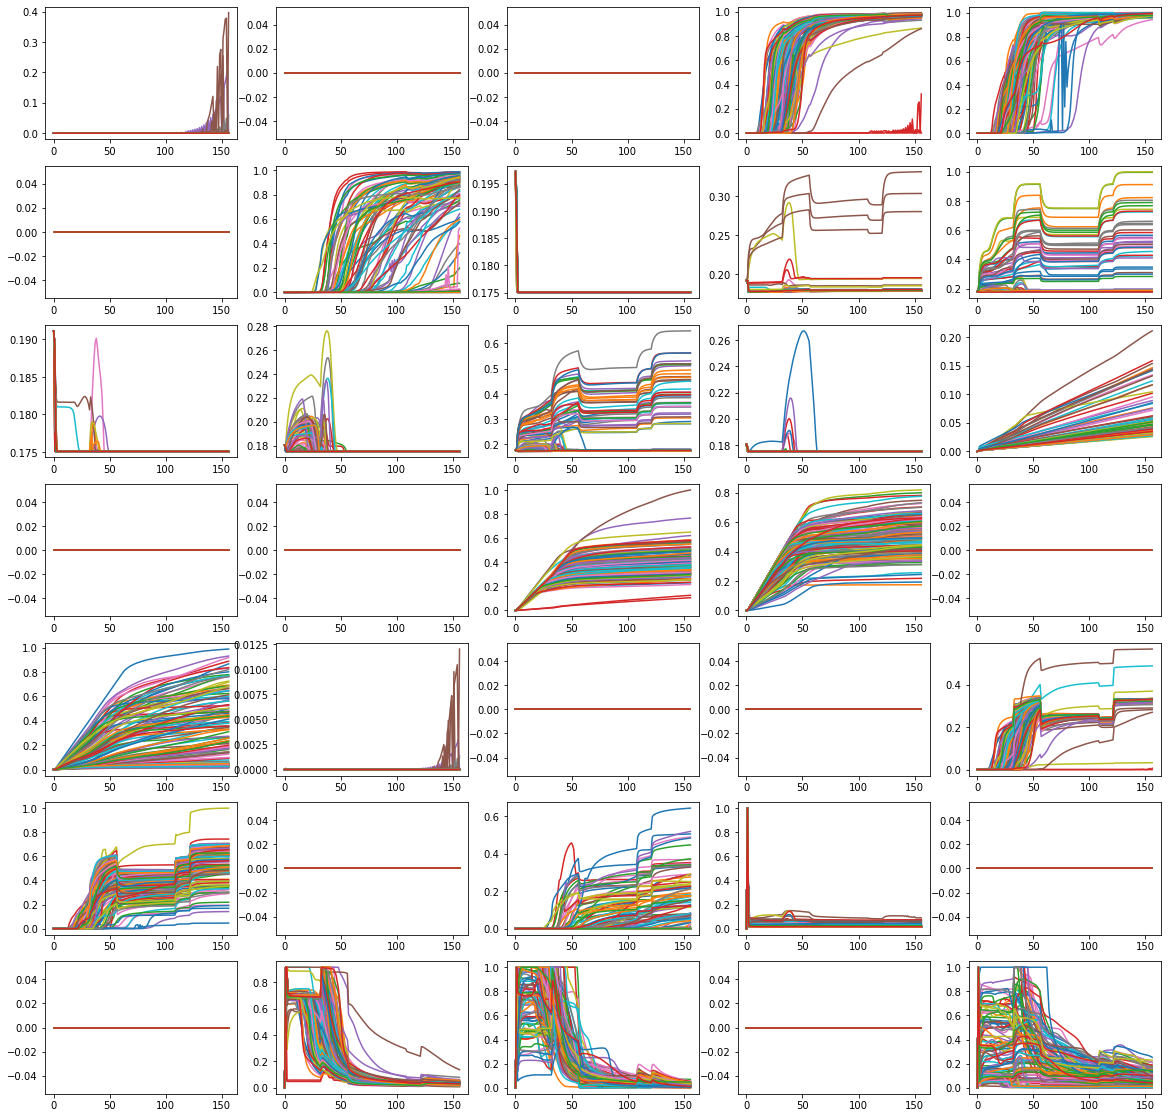

In [4]:
#filter for when bhp/rate controls are changed

f = plt.figure(figsize=(20,20))
for j in range(35):
    ax = f.add_subplot(7, 5, j+1)
    for i in range(D0.shape[0]):
        plt.plot(D0[i,:,j])

In [5]:
Dtrain = D0
print(Dtrain.shape)

(124, 157, 35)


# Data Autoencoder

In [6]:
#define Keras classes

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

from tensorflow.keras.layers import Dense, Dropout, Flatten, Multiply, Reshape
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Input, UpSampling2D, UpSampling3D
from tensorflow.keras import backend as K

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output

from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector

from tensorflow.keras.callbacks import History 

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss", c = 'green')
        plt.plot(self.x, self.val_losses, label="val_loss", c = 'red')
        plt.legend()
        plt.show()

In [7]:
#copy from above to access latent variables 
input_dt = Input(shape=(157, 35))

# define data encoder
_ = Conv1D(16*2, 3, activation='relu', padding='same', data_format='channels_last')(input_dt)
_ = MaxPooling1D(2, padding="same")(_)
_ = Conv1D(8*2, 6, activation='relu', padding='same', data_format='channels_last')(_)
_ = MaxPooling1D(2, padding="same")(_)
_ = Conv1D(4*2, 9, activation='relu', padding='same', data_format='channels_last')(_)
_ = MaxPooling1D(2, padding="same")(_)
_ = Conv1D(2*2, 12, activation='relu', padding='same', data_format='channels_last')(_)
_ = MaxPooling1D(2, padding="same")(_)
_ = Reshape((10*2*2,))(_)
encoded_d = Dense(10*2, activation='linear')(_)

# define data decoder
_ = Dense(10*2*2, activation='linear')(encoded_d)
_ = Reshape((10, 2*2))(_)
_ = Conv1D(2*2, 12, activation='relu', padding='same', data_format='channels_last')(_)
_ = UpSampling1D(2)(_)
_ = Conv1D(4*2, 9, activation='relu', padding='same', data_format='channels_last')(_)
_ = UpSampling1D(2)(_)
_ = Conv1D(8*2, 6, activation='relu', padding='same', data_format='channels_last')(_)
_ = UpSampling1D(2)(_)
_ = Conv1D(16*2, 3, activation='relu', padding='same', data_format='channels_last')(_)
_ = UpSampling1D(2)(_)
decoded_d = Conv1D(35, 4, activation='linear', padding='valid')(_)

# define model and compile
LSI_dataAE = Model(input_dt, decoded_d)
opt = keras.optimizers.Adam(lr=1e-3)
LSI_dataAE.compile(optimizer=opt, loss='mean_squared_error')
LSI_dataAE.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 157, 35)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 157, 32)           3392      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 79, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 79, 16)            3088      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 8)             1160      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 8)             0     

D:\13108\anaconda3\envs\Py36\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


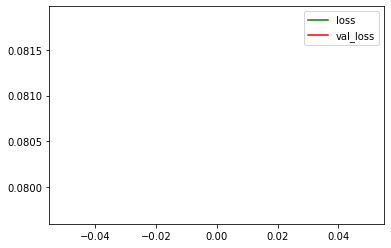

In [8]:
plot_losses = PlotLosses()
LSI_dataAE.fit(Dtrain, Dtrain,        
                epochs=1,
                batch_size=128,
                shuffle=True,
                validation_split=0.1,
                callbacks=[plot_losses])

In [9]:
#predict both vars
Dtrain_hat = LSI_dataAE.predict(Dtrain)

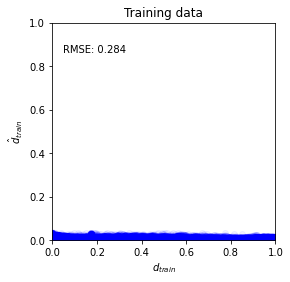

In [10]:
def RMSE(data1, data2):
    return np.sqrt(np.mean((data1.flatten()-data2.flatten())**2))

#scatter plots for training and testing, color by field label
def scatterPlot(data1, data2, xlabel, ylabel, color, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.scatter(data1, data2, c=color, alpha=0.05)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title(title)
    ax.annotate(f"RMSE: {RMSE(data1, data2):.3f}", xy=(0.8, 0.8),  xycoords='data',
            xytext=(0.05, 0.9), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top')
    
scatterPlot(Dtrain, Dtrain_hat, '$d_{train}$', '$\hat{d}_{train}$', 'b', 'Training data')